In [ ]:
! pip install pytorch_tabular[all]

## Imports

In [ ]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import os
import random
np.random.seed(0)


import os
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%load_ext autoreload

%autoreload 2

#Sklearn only for splitting
from sklearn.model_selection import KFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper Functions

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def preprocess_data(train, train_indices):

  nunique = train.nunique()
  print(nunique)
  types = train.dtypes
  print(types)

  categorical_columns = []
  categorical_dims =  {}
  for col in train.columns:
      if types[col] == 'object' or nunique[col] < 200:
          print(col, train[col].nunique())
          l_enc = LabelEncoder()
          train[col] = train[col].fillna("VV_likely")
          train[col] = l_enc.fit_transform(train[col].values)
          categorical_columns.append(col)
          categorical_dims[col] = len(l_enc.classes_)
      else:
          train.fillna(train.loc[train_indices, col].mean(), inplace=True)
  
  return categorical_columns, categorical_dims


In [ ]:
def split_traindata(train_df):
  if "Set" not in train_df.columns:
    train_df["Set"] = np.random.choice(["train", "valid", "test"], p =[.75, .125, .125], size=(train_df.shape[0],))

  train_indices = train_df[train_df.Set=="train"].index
  valid_indices = train_df[train_df.Set=="valid"].index
  test_indices = train_df[train_df.Set=="test"].index

  return train_indices, valid_indices, test_indices

In [ ]:
def cat_features(train, target, categorical_columns, categorical_dims):
  unused_feat = ['Set']
  features = [ col for col in train.columns if col not in unused_feat+[target]] 
  cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
  cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
  return features, cat_idxs, cat_dims

In [ ]:
def final_data(train, target, features, train_indices, valid_indices, test_indices):
  X_train = train[features].values[train_indices]
  y_train = train[target].values[train_indices]
  X_valid = train[features].values[valid_indices]
  y_valid = train[target].values[valid_indices]
  X_test = train[features].values[test_indices]
  y_test = train[target].values[test_indices]
  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
def my_loss_fn(y_pred, y_true):
    """
    Dummy example similar to using default torch.nn.functional.cross_entropy
    """
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1-y_true)*torch.log(softmax_pred[:,0])
    logloss += y_true*torch.log(softmax_pred[:,1])
    return -torch.mean(logloss)

In [ ]:
def model(max_epochs, batch_size, cat_idxs, cat_dims, train):
  clf = TabNetClassifier(cat_idxs = cat_idxs,
                       cat_dims = cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='sparsemax', # "entmax",
                      )
  return clf

In [ ]:
def training(X_train, X_valid, y_train, y_valid, train, val, clf):

  clf.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'val'],
      eval_metric=["auc", 'logloss', 'accuracy'],
      max_epochs= max_epochs, patience = 30,
      batch_size= batch_size,
      virtual_batch_size= 64,
      num_workers=0,
      weights=1,
      drop_last=False,
      loss_fn=my_loss_fn
  )

In [ ]:
class my_metric(Metric):
    """
    2xAUC.
    """

    def __init__(self):
        self._name = "custom" # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute AUC of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            AUC of predictions vs targets.
        """
        return 2*roc_auc_score(y_true, y_score[:, 1])

In [ ]:
def test_model(X_test, y_test, X_valid, y_valid, clf):

  test_preds_prob = clf.predict_proba(X_test)
  test_preds_bin = clf.predict(X_test)
  test_auc = roc_auc_score(y_score=test_preds_prob[:,1], y_true=y_test)
  test_accuracy = accuracy_score(y_true = y_test, y_pred = test_preds_bin)

  valid_preds_prob = clf.predict_proba(X_valid)
  valid_preds_bin = clf.predict(X_valid)
  # valid_auc = roc_auc_score(y_score=valid_preds_prob[:,1], y_true=y_test)
  # valid_accuracy = accuracy_score(y_true = y_test, y_pred = valid_preds_bin)


  print(f"FINAL VALID AUC_SCORE: {clf.history['val_auc'][-1]}")
  print(f"FINAL VALID ACCURACY_SCORE: {clf.history['val_accuracy'][-1]}")
  print(f"FINAL TEST ACCURACY_SCORE: {test_accuracy}")
  print(f"FINAL TEST AUC_SCORE: {test_auc}")
  # print(f"FINAL valid ACCURACY_SCORE: {valid_accuracy}")
  # print(f"FINAL valid AUC_SCORE: {valid_auc}")
  


## Load & Preprocess

In [ ]:
max_epochs = 500
batch_size = 2048

In [ ]:
NUM_FOLDS = 7  # you can specify your folds here
seed = 2020

In [ ]:
seed_everything(seed)

## 5-6

### Data

In [ ]:
df1 = pd.read_csv('5-6_Balanced_Stunting.csv')
df2 = pd.read_csv('5-6_Balanced_Wasting.csv')
df3 = pd.read_csv('5-6_Balanced_Stunted_Wasting.csv')

In [ ]:
df1 = df1.drop(['Unnamed: 0'], axis =1)
df2 = df2.drop(['Unnamed: 0'], axis = 1)
df3 = df3.drop(['Unnamed: 0'], axis =1)

In [ ]:
train1_indices, valid1_indices, test1_indices = split_traindata(df1)
train2_indices, valid2_indices, test2_indices = split_traindata(df2)
train3_indices, valid3_indices, test3_indices = split_traindata(df3)
# train4_indices, valid4_indices, test4_indices = split_traindata(train4)

In [ ]:
categorical_columns1, categorical_dims1 = preprocess_data(df1, train1_indices)
categorical_columns2, categorical_dims2 = preprocess_data(df2, train2_indices)
categorical_columns3, categorical_dims3 = preprocess_data(df3, train3_indices)

state                                  6
area                                   2
religion                               5
caste                                  4
type of family                         3
father's education                     4
father's occupation                    7
mother's education                     4
mother's occupation                    7
total family members                  32
exposure to mass media                 2
Source of drinking water               2
Toilet Facility                        2
mother's age                           4
mother's bmi                           3
child's age                            7
sex of child                           2
birth weight                           3
initiation of bf(early initiation)     2
wealth index                           5
months of bf                           2
history of illness                     2
immunization                           3
index to birth history                 5
no of living chi

In [ ]:
features1, cat_idxs1, cat_dims1 = cat_features(df1, 'H/A', categorical_columns1, categorical_dims1)
features2, cat_idxs2, cat_dims2 = cat_features(df2, 'W/H', categorical_columns2, categorical_dims2)
features3, cat_idxs3, cat_dims3 = cat_features(df3, 'HAWH', categorical_columns3, categorical_dims3)

In [ ]:
clf1 = model(500, 1024, cat_idxs1, cat_dims1, df1)
clf2 = model(500, 1024, cat_idxs2, cat_dims2, df2)
clf3 = model(500, 1024, cat_idxs3, cat_dims3, df3)

Device used : cuda
Device used : cuda
Device used : cuda


In [ ]:
X_train1, X_valid1, X_test1, y_train1, y_valid1, y_test1 = final_data(df1, 'H/A', features1, train1_indices, valid1_indices, test1_indices)
X_train2, X_valid2, X_test2, y_train2, y_valid2, y_test2 = final_data(df2, 'W/H', features2, train2_indices, valid2_indices, test2_indices)
X_train3, X_valid3, X_test3, y_train3, y_valid3, y_test3 = final_data(df3, 'HAWH', features3, train3_indices, valid3_indices, test3_indices)

###  H/A

In [ ]:
training(X_train1, X_valid1, y_train1, y_valid1, 'train1', 'val1', clf1)

epoch 0  | loss: 0.7288  | train_auc: 0.51516 | train_logloss: 0.71122 | train_accuracy: 0.52162 | val_auc: 0.51582 | val_logloss: 0.71369 | val_accuracy: 0.51954 |  0:00:03s
epoch 1  | loss: 0.70698 | train_auc: 0.52403 | train_logloss: 0.69381 | train_accuracy: 0.52578 | val_auc: 0.5187  | val_logloss: 0.69611 | val_accuracy: 0.52326 |  0:00:07s
epoch 2  | loss: 0.69601 | train_auc: 0.53512 | train_logloss: 0.69254 | train_accuracy: 0.5238  | val_auc: 0.53203 | val_logloss: 0.69395 | val_accuracy: 0.52346 |  0:00:10s
epoch 3  | loss: 0.69178 | train_auc: 0.54453 | train_logloss: 0.69227 | train_accuracy: 0.52657 | val_auc: 0.53751 | val_logloss: 0.69427 | val_accuracy: 0.51974 |  0:00:13s
epoch 4  | loss: 0.69108 | train_auc: 0.55064 | train_logloss: 0.69164 | train_accuracy: 0.52408 | val_auc: 0.55011 | val_logloss: 0.69294 | val_accuracy: 0.52471 |  0:00:17s
epoch 5  | loss: 0.6863  | train_auc: 0.56005 | train_logloss: 0.69078 | train_accuracy: 0.52813 | val_auc: 0.56371 | val_log

Text(0.5, 1.0, 'Loss for HA')

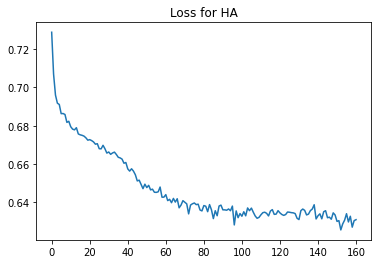

In [ ]:
# plot losses
plt.plot(clf1.history['loss'])
plt.title('Loss for HA')

Text(0.5, 1.0, 'Accuracies for HA')

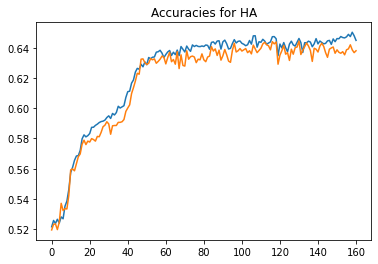

In [ ]:
plt.plot(clf1.history['train_accuracy'])
plt.plot(clf1.history['val_accuracy'])
plt.title('Accuracies for HA')

Text(0.5, 1.0, 'Area Under the Curve for HA')

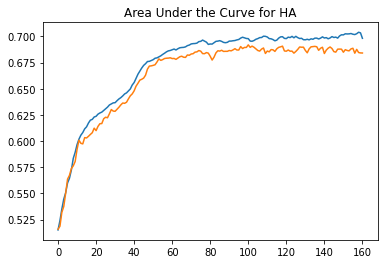

In [ ]:
# plot auc
plt.plot(clf1.history['train_auc'])
plt.plot(clf1.history['val_auc'])
plt.title('Area Under the Curve for HA')

Text(0.5, 1.0, 'Learning rates for HA')

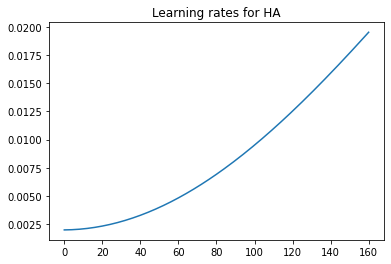

In [ ]:
# plot learning rates
plt.plot(clf1.history['lr'])
plt.title('Learning rates for HA')

In [ ]:
test_model(X_test1, y_test1, X_valid1, y_valid1, clf1)

FINAL VALID AUC_SCORE: 0.6842216638968854
FINAL VALID ACCURACY_SCORE: 0.6379987595617118
FINAL TEST ACCURACY_SCORE: 0.6425785259700267
FINAL TEST AUC_SCORE: 0.6779759983354429


In [ ]:
test_model(X_train1, y_train1, X_valid1, y_valid1, clf1)

FINAL VALID AUC_SCORE: 0.6842216638968854
FINAL VALID ACCURACY_SCORE: 0.6379987595617118
FINAL TEST ACCURACY_SCORE: 0.646116620659101
FINAL TEST AUC_SCORE: 0.6968507039921282


In [ ]:
# os.mkdir('models')

In [ ]:
# # save tabnet model 
# saving_path_name = "/content/models/tabnet_basic_HA"
# saved_filepath = clf1.save_model(saving_path_name)

In [ ]:
# # define new model with basic parameters and load state dict weights
# loaded_clf1 = TabNetClassifier()
# loaded_clf1.load_model(saved_filepath)

### W/H

In [ ]:
training(X_train2, X_valid2, y_train2, y_valid2, 'train2', 'val2', clf2)

epoch 0  | loss: 0.81913 | train_auc: 0.51279 | train_logloss: 0.73885 | train_accuracy: 0.50711 | val_auc: 0.49518 | val_logloss: 0.74871 | val_accuracy: 0.49589 |  0:00:05s
epoch 1  | loss: 0.72957 | train_auc: 0.51947 | train_logloss: 0.70446 | train_accuracy: 0.51446 | val_auc: 0.5026  | val_logloss: 0.71121 | val_accuracy: 0.50895 |  0:00:10s
epoch 2  | loss: 0.69935 | train_auc: 0.53749 | train_logloss: 0.69783 | train_accuracy: 0.53043 | val_auc: 0.52588 | val_logloss: 0.70239 | val_accuracy: 0.52423 |  0:00:15s
epoch 3  | loss: 0.68517 | train_auc: 0.56046 | train_logloss: 0.6909  | train_accuracy: 0.54619 | val_auc: 0.55456 | val_logloss: 0.6936  | val_accuracy: 0.54133 |  0:00:20s
epoch 4  | loss: 0.67794 | train_auc: 0.57544 | train_logloss: 0.68945 | train_accuracy: 0.55145 | val_auc: 0.57464 | val_logloss: 0.68974 | val_accuracy: 0.55139 |  0:00:25s
epoch 5  | loss: 0.67466 | train_auc: 0.59435 | train_logloss: 0.68114 | train_accuracy: 0.56495 | val_auc: 0.59212 | val_log

Text(0.5, 1.0, 'Loss for W/H')

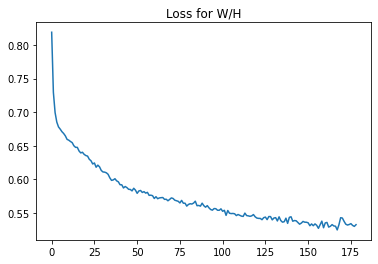

In [ ]:
# plot losses
plt.plot(clf2.history['loss'])
plt.title('Loss for W/H')

In [ ]:
test_model(X_test2, y_test2, X_valid2, y_valid2, clf2)

FINAL VALID AUC_SCORE: 0.8004029555168017
FINAL VALID ACCURACY_SCORE: 0.7265247485960559
FINAL TEST ACCURACY_SCORE: 0.7241515390686661
FINAL TEST AUC_SCORE: 0.7993806679784967


In [ ]:
test_model(X_train2, y_train2, X_valid2, y_valid2, clf2)

FINAL VALID AUC_SCORE: 0.8004029555168017
FINAL VALID ACCURACY_SCORE: 0.7265247485960559
FINAL TEST ACCURACY_SCORE: 0.7421117303725808
FINAL TEST AUC_SCORE: 0.8144811263386651


Text(0.5, 1.0, 'Accuracies for WH')

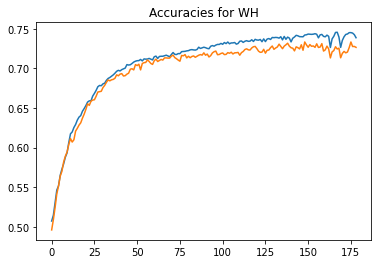

In [ ]:
plt.plot(clf2.history['train_accuracy'])
plt.plot(clf2.history['val_accuracy'])
plt.title('Accuracies for WH')

Text(0.5, 1.0, 'Learning rates for WH')

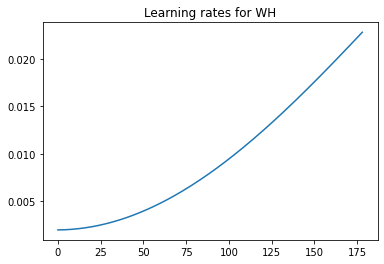

In [ ]:
# plot learning rates
plt.plot(clf2.history['lr'])
plt.title('Learning rates for WH')

Text(0.5, 1.0, 'Area under the curves for WH')

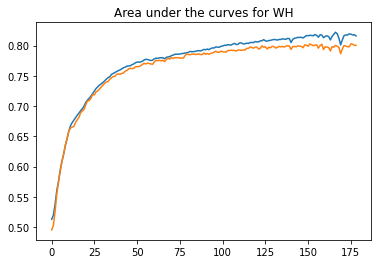

In [ ]:
plt.plot(clf2.history['train_auc'])
plt.plot(clf2.history['val_auc'])
plt.title('Area under the curves for WH')

In [ ]:
# # save tabnet model 
# saving_path_name = "/content/models/tabnet_WA_bs=2048"
# saved_filepath = clf2.save_model(saving_path_name)

### HAWH

In [ ]:
training(X_train3, X_valid3, y_train3, y_valid3, 'train3', 'val3', clf3)

epoch 0  | loss: 1.27112 | train_auc: 0.5491  | train_logloss: 0.90322 | train_accuracy: 0.50382 | val_auc: 0.55176 | val_logloss: 0.88503 | val_accuracy: 0.50863 |  0:00:10s
epoch 1  | loss: 0.79463 | train_auc: 0.58568 | train_logloss: 0.70391 | train_accuracy: 0.56489 | val_auc: 0.58728 | val_logloss: 0.70079 | val_accuracy: 0.56259 |  0:00:22s
epoch 2  | loss: 0.69589 | train_auc: 0.61469 | train_logloss: 0.68233 | train_accuracy: 0.57965 | val_auc: 0.61097 | val_logloss: 0.68439 | val_accuracy: 0.5761  |  0:00:33s
epoch 3  | loss: 0.67234 | train_auc: 0.62993 | train_logloss: 0.6701  | train_accuracy: 0.59363 | val_auc: 0.63255 | val_logloss: 0.66911 | val_accuracy: 0.5978  |  0:00:44s
epoch 4  | loss: 0.66247 | train_auc: 0.64718 | train_logloss: 0.66098 | train_accuracy: 0.61494 | val_auc: 0.64983 | val_logloss: 0.66    | val_accuracy: 0.6179  |  0:00:54s
epoch 5  | loss: 0.65402 | train_auc: 0.66634 | train_logloss: 0.65212 | train_accuracy: 0.62895 | val_auc: 0.66508 | val_log

Text(0.5, 1.0, 'Loss for HAWH')

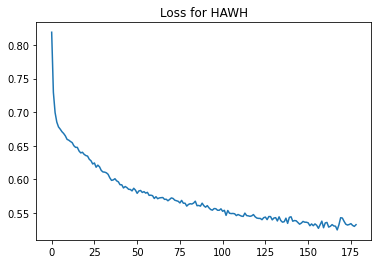

In [ ]:
# plot losses
plt.plot(clf2.history['loss'])
plt.title('Loss for HAWH')

In [ ]:
test_model(X_test3, y_test3, X_valid3, y_valid3, clf3)

FINAL VALID AUC_SCORE: 0.8972858138251735
FINAL VALID ACCURACY_SCORE: 0.8196274420717855
FINAL TEST ACCURACY_SCORE: 0.8122439690487028
FINAL TEST AUC_SCORE: 0.8918147046107916


In [ ]:
test_model(X_train3, y_train3, X_valid3, y_valid3, clf3)

FINAL VALID AUC_SCORE: 0.8972858138251735
FINAL VALID ACCURACY_SCORE: 0.8196274420717855
FINAL TEST ACCURACY_SCORE: 0.8336191448775506
FINAL TEST AUC_SCORE: 0.9111982438171803


Text(0.5, 1.0, 'Accuracies for HAWH')

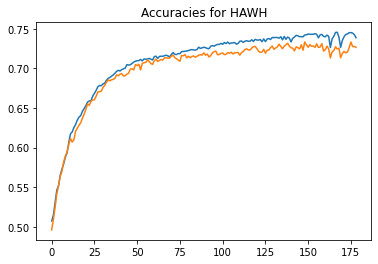

In [ ]:
plt.plot(clf2.history['train_accuracy'])
plt.plot(clf2.history['val_accuracy'])
plt.title('Accuracies for HAWH')

Text(0.5, 1.0, 'Learning rates for HAWH')

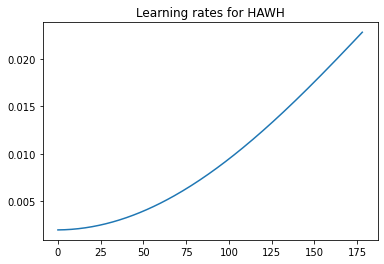

In [ ]:
# plot learning rates
plt.plot(clf2.history['lr'])
plt.title('Learning rates for HAWH')

Text(0.5, 1.0, 'Area under the curves for HAWH')

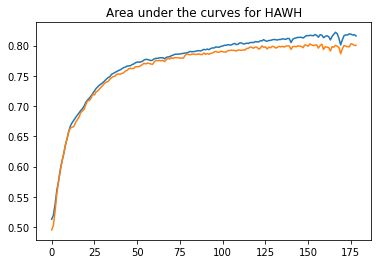

In [ ]:
plt.plot(clf2.history['train_auc'])
plt.plot(clf2.history['val_auc'])
plt.title('Area under the curves for HAWH')

In [ ]:
# # save tabnet model 
# saving_path_name = "/content/models/tabnet_WA_bs=2048"
# saved_filepath = clf2.save_model(saving_path_name)

## 15-16

### Data

In [ ]:
df1 = pd.read_csv('15-16_Balanced_Stunting.csv')
df2 = pd.read_csv('15-16_Balanced_Wasting.csv')
df3 = pd.read_csv('15-16_Balanced_Stunted_Wasting.csv')

In [ ]:
df1 = df1.drop(['Unnamed: 0'], axis =1)
df2 = df2.drop(['Unnamed: 0'], axis = 1)
df3 = df3.drop(['Unnamed: 0'], axis =1)

In [ ]:
train1_indices, valid1_indices, test1_indices = split_traindata(df1)
train2_indices, valid2_indices, test2_indices = split_traindata(df2)
train3_indices, valid3_indices, test3_indices = split_traindata(df3)

In [ ]:
categorical_columns1, categorical_dims1 = preprocess_data(df1, train1_indices)
categorical_columns2, categorical_dims2 = preprocess_data(df2, train2_indices)
categorical_columns3, categorical_dims3 = preprocess_data(df3, train3_indices)

State                           6
Area                            2
Religion                        5
caste                           4
mothers education               4
source of water                 2
toilet facility                 2
no of members                  36
no of living children          13
mothers age(at first birth)     4
sex of household head           2
wealth index                    5
initiaion of bf                 2
sex of child                    2
months of bf                    2
mothers bmi                     3
child's age                     7
index to birth history          5
birth weight                    3
history of illness              2
Exposure to mass media          2
dietary score                  15
immunization                    3
H/A                             2
Set                             3
dtype: int64
State                           int64
Area                            int64
Religion                        int64
caste                  

In [ ]:
features1, cat_idxs1, cat_dims1 = cat_features(df1, 'H/A', categorical_columns1, categorical_dims1)
features2, cat_idxs2, cat_dims2 = cat_features(df2, 'W/H', categorical_columns2, categorical_dims2)
features3, cat_idxs3, cat_dims3 = cat_features(df3, 'HAWH', categorical_columns3, categorical_dims3)

In [ ]:
clf1 = model(500, 1024, cat_idxs1, cat_dims1, df1)
clf2 = model(500, 1024, cat_idxs2, cat_dims2, df2)
clf3 = model(500, 1024, cat_idxs3, cat_dims3, df3)

Device used : cuda
Device used : cuda
Device used : cuda


In [ ]:
X_train1, X_valid1, X_test1, y_train1, y_valid1, y_test1 = final_data(df1, 'H/A', features1, train1_indices, valid1_indices, test1_indices)
X_train2, X_valid2, X_test2, y_train2, y_valid2, y_test2 = final_data(df2, 'W/H', features2, train2_indices, valid2_indices, test2_indices)
X_train3, X_valid3, X_test3, y_train3, y_valid3, y_test3 = final_data(df3, 'HAWH', features3, train3_indices, valid3_indices, test3_indices)

###  H/A

In [ ]:
training(X_train1, X_valid1, y_train1, y_valid1, 'train1', 'val1', clf1)

epoch 0  | loss: 0.79401 | train_auc: 0.52712 | train_logloss: 0.70417 | train_accuracy: 0.51911 | val_auc: 0.52388 | val_logloss: 0.70446 | val_accuracy: 0.5153  |  0:00:21s
epoch 1  | loss: 0.69988 | train_auc: 0.573   | train_logloss: 0.68595 | train_accuracy: 0.55565 | val_auc: 0.57087 | val_logloss: 0.68609 | val_accuracy: 0.55344 |  0:00:44s
epoch 2  | loss: 0.68841 | train_auc: 0.5911  | train_logloss: 0.68077 | train_accuracy: 0.56791 | val_auc: 0.59025 | val_logloss: 0.68099 | val_accuracy: 0.56669 |  0:01:17s
epoch 3  | loss: 0.68252 | train_auc: 0.60415 | train_logloss: 0.67666 | train_accuracy: 0.576   | val_auc: 0.60241 | val_logloss: 0.67694 | val_accuracy: 0.573   |  0:01:39s
epoch 4  | loss: 0.6799  | train_auc: 0.61275 | train_logloss: 0.67364 | train_accuracy: 0.58306 | val_auc: 0.61084 | val_logloss: 0.67419 | val_accuracy: 0.58171 |  0:02:01s
epoch 5  | loss: 0.67581 | train_auc: 0.62131 | train_logloss: 0.67058 | train_accuracy: 0.58857 | val_auc: 0.61803 | val_log

Text(0.5, 1.0, 'Loss for HA')

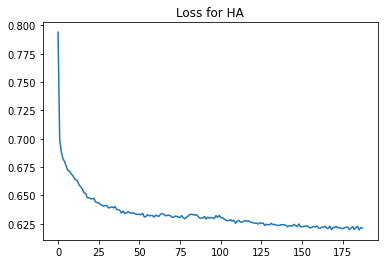

In [ ]:
# plot losses
plt.plot(clf1.history['loss'])
plt.title('Loss for HA')

Text(0.5, 1.0, 'Accuracies for HA')

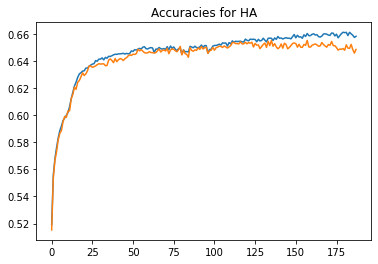

In [ ]:
plt.plot(clf1.history['train_accuracy'])
plt.plot(clf1.history['val_accuracy'])
plt.title('Accuracies for HA')

Text(0.5, 1.0, 'Area Under the Curve for HA')

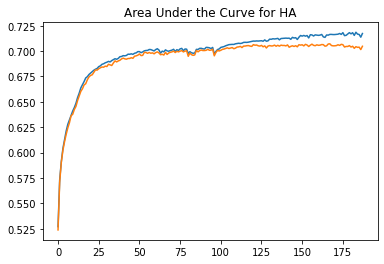

In [ ]:
# plot auc
plt.plot(clf1.history['train_auc'])
plt.plot(clf1.history['val_auc'])
plt.title('Area Under the Curve for HA')

Text(0.5, 1.0, 'Learning rates for HA')

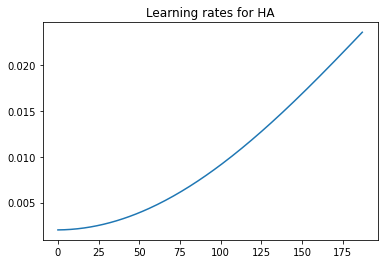

In [ ]:
# plot learning rates
plt.plot(clf1.history['lr'])
plt.title('Learning rates for HA')

In [ ]:
test_model(X_test1, y_test1, X_valid1, y_valid1, clf1)

FINAL VALID AUC_SCORE: 0.7047052250663484
FINAL VALID ACCURACY_SCORE: 0.6485724356714839
FINAL TEST ACCURACY_SCORE: 0.6512234327558493
FINAL TEST AUC_SCORE: 0.7053251449459477


In [ ]:
test_model(X_train1, y_train1, X_valid1, y_valid1, clf1)

In [ ]:
# os.mkdir('models')

In [ ]:
# # save tabnet model 
# saving_path_name = "/content/models/tabnet_basic_HA"
# saved_filepath = clf1.save_model(saving_path_name)

In [ ]:
# # define new model with basic parameters and load state dict weights
# loaded_clf1 = TabNetClassifier()
# loaded_clf1.load_model(saved_filepath)

### W/H

In [ ]:
training(X_train2, X_valid2, y_train2, y_valid2, 'train2', 'val2', clf2)

epoch 0  | loss: 0.7535  | train_auc: 0.56471 | train_logloss: 0.69423 | train_accuracy: 0.54307 | val_auc: 0.56573 | val_logloss: 0.69348 | val_accuracy: 0.54206 |  0:00:29s
epoch 1  | loss: 0.68598 | train_auc: 0.58506 | train_logloss: 0.68505 | train_accuracy: 0.55771 | val_auc: 0.59075 | val_logloss: 0.68367 | val_accuracy: 0.56027 |  0:00:53s
epoch 2  | loss: 0.6789  | train_auc: 0.60339 | train_logloss: 0.67999 | train_accuracy: 0.56694 | val_auc: 0.60888 | val_logloss: 0.67899 | val_accuracy: 0.56595 |  0:01:19s
epoch 3  | loss: 0.67279 | train_auc: 0.62218 | train_logloss: 0.67495 | train_accuracy: 0.57966 | val_auc: 0.62708 | val_logloss: 0.67366 | val_accuracy: 0.58223 |  0:01:43s
epoch 4  | loss: 0.66672 | train_auc: 0.64019 | train_logloss: 0.66697 | train_accuracy: 0.59803 | val_auc: 0.64395 | val_logloss: 0.66566 | val_accuracy: 0.60023 |  0:02:08s
epoch 5  | loss: 0.66246 | train_auc: 0.65286 | train_logloss: 0.65984 | train_accuracy: 0.61047 | val_auc: 0.65705 | val_log

Text(0.5, 1.0, 'Loss for W/H')

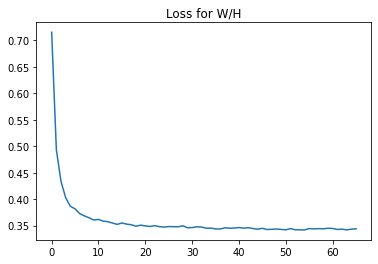

In [ ]:
# plot losses
plt.plot(clf2.history['loss'])
plt.title('Loss for W/H')

In [ ]:
test_model(X_test2, y_test2, X_valid2, y_valid2, clf2)

FINAL VALID AUC_SCORE: 0.8900024246792724
FINAL VALID ACCURACY_SCORE: 0.8590272792534099
FINAL TEST ACCURACY_SCORE: 0.8630372492836677
FINAL TEST AUC_SCORE: 0.8901869733293497


In [ ]:
test_model(X_train2, y_train2, X_valid2, y_valid2, clf2)

FINAL VALID AUC_SCORE: 0.8900024246792724
FINAL VALID ACCURACY_SCORE: 0.8590272792534099
FINAL TEST ACCURACY_SCORE: 0.8580628734891941
FINAL TEST AUC_SCORE: 0.8857843929628668


Text(0.5, 1.0, 'Accuracies for WH')

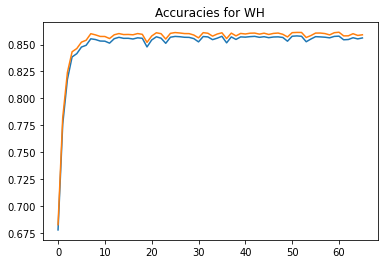

In [ ]:
plt.plot(clf2.history['train_accuracy'])
plt.plot(clf2.history['val_accuracy'])
plt.title('Accuracies for WH')

Text(0.5, 1.0, 'Learning rates for WH')

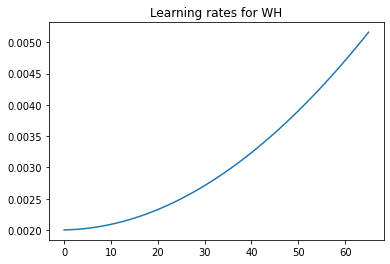

In [ ]:
# plot learning rates
plt.plot(clf2.history['lr'])
plt.title('Learning rates for WH')

Text(0.5, 1.0, 'Area under the curves for WH')

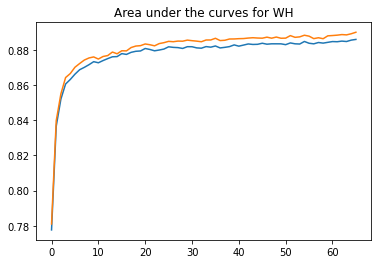

In [ ]:
plt.plot(clf2.history['train_auc'])
plt.plot(clf2.history['val_auc'])
plt.title('Area under the curves for WH')

In [ ]:
# # save tabnet model 
# saving_path_name = "/content/models/tabnet_WA_bs=2048"
# saved_filepath = clf2.save_model(saving_path_name)

### HAWH

In [ ]:
training(X_train3, X_valid3, y_train3, y_valid3, 'train3', 'val3', clf3)

epoch 0  | loss: 0.52968 | train_auc: 0.92662 | train_logloss: 0.38557 | train_accuracy: 0.81004 | val_auc: 0.92759 | val_logloss: 0.3836  | val_accuracy: 0.80979 |  0:00:30s
epoch 1  | loss: 0.2148  | train_auc: 0.96597 | train_logloss: 0.2034  | train_accuracy: 0.92352 | val_auc: 0.96548 | val_logloss: 0.2043  | val_accuracy: 0.92375 |  0:01:01s
epoch 2  | loss: 0.16863 | train_auc: 0.96963 | train_logloss: 0.15174 | train_accuracy: 0.95347 | val_auc: 0.9682  | val_logloss: 0.15444 | val_accuracy: 0.95265 |  0:01:30s
epoch 3  | loss: 0.15754 | train_auc: 0.97055 | train_logloss: 0.14098 | train_accuracy: 0.96105 | val_auc: 0.96883 | val_logloss: 0.14384 | val_accuracy: 0.96059 |  0:02:00s
epoch 4  | loss: 0.15004 | train_auc: 0.97102 | train_logloss: 0.13876 | train_accuracy: 0.96293 | val_auc: 0.96992 | val_logloss: 0.1411  | val_accuracy: 0.96254 |  0:02:30s
epoch 5  | loss: 0.14564 | train_auc: 0.97135 | train_logloss: 0.13776 | train_accuracy: 0.96319 | val_auc: 0.96999 | val_log

In [ ]:
# plot losses
plt.plot(clf2.history['loss'])
plt.title('Loss for HAWH')

In [ ]:
test_model(X_test3, y_test3, X_valid3, y_valid3, clf3)

FINAL VALID AUC_SCORE: 0.972758897367551
FINAL VALID ACCURACY_SCORE: 0.9636359098509996
FINAL TEST ACCURACY_SCORE: 0.9646770400760495
FINAL TEST AUC_SCORE: 0.9719251864825134


In [ ]:
test_model(X_train3, y_train3, X_valid3, y_valid3, clf3)

FINAL VALID AUC_SCORE: 0.972758897367551
FINAL VALID ACCURACY_SCORE: 0.9636359098509996
FINAL TEST ACCURACY_SCORE: 0.9651025944905788
FINAL TEST AUC_SCORE: 0.9721663134674872


In [ ]:
plt.plot(clf2.history['train_accuracy'])
plt.plot(clf2.history['val_accuracy'])
plt.title('Accuracies for HAWH')

AttributeError: ignored

In [ ]:
# plot learning rates
plt.plot(clf2.history['lr'])
plt.title('Learning rates for HAWH')

In [ ]:
plt.plot(clf2.history['train_auc'])
plt.plot(clf2.history['val_auc'])
plt.title('Area under the curves for HAWH')

In [ ]:
# # save tabnet model 
# saving_path_name = "/content/models/tabnet_WA_bs=2048"
# saved_filepath = clf2.save_model(saving_path_name)